### [Introduction to Brian part 3: Simulations](https://brian2.readthedocs.io/en/stable/resources/tutorials/3-intro-to-brian-simulations.html)

In [1]:
from brian2 import *
%matplotlib inline
import time

done in : 16.719433069229126


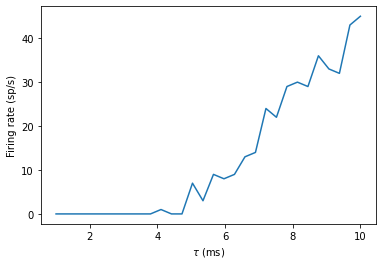

In [9]:
# remember, this is here for running separate simulations in the same notebook
start_scope()

start_time = time.time()
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1

# Range of time constants
tau_range = linspace(1, 10, 30)*ms

# Use this list to store output rates
output_rates = []

# Iterate over range of time constants
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(num_inputs, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau: 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S=Synapses(P, G, on_pre='v+=weight')
    S.connect()
    M = SpikeMonitor(G)
    
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)

# And plot it
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

print("done in : {}".format(time.time()-start_time))

done in : 15.902045488357544


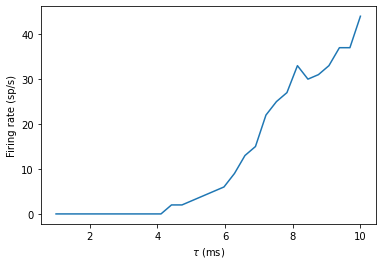

In [10]:
start_scope()

start_time = time.time()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []

# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()

for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)

plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

print("done in : {}".format(time.time()-start_time))

done in : 28.371515035629272


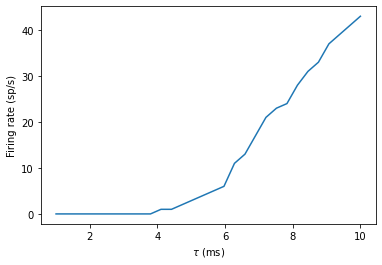

In [12]:
start_scope()
start_time = time.time()

num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms

output_rates = []

# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)

# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)

# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t

# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)

# Store the current state of the network
net = Network(SGG, G, S, M)
net.store()
for tau in tau_range:
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');
print("done in : {}".format(time.time()-start_time))

WARNING    "tau" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


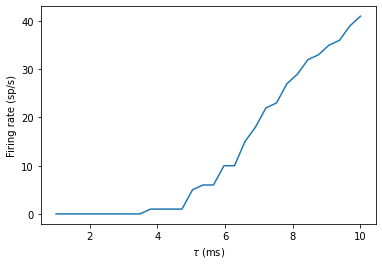

In [13]:
start_time = time.time()
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
num_tau = len(tau_range)
P = PoissonGroup(num_inputs, rates=input_rate)

# We make tau a parameter of the group
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''

# And we have num_tau output neurons, each with a different tau
G = NeuronGroup(num_tau, eqs, threshold='v>1', reset='v=0', method='exact')
G.tau = tau_range
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)

# Now we can just run once with no loop
run(1*second)
output_rates = M.count/second # firing rate is count/duration
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

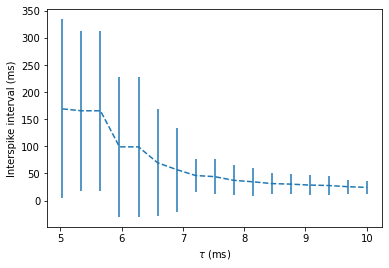

In [19]:
trains = M.spike_trains()
isi_mu = full(num_tau, nan) *second
isi_std = full(num_tau, nan) *second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train) > 1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms, ls='--')
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');